In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import lightgbm
from lightgbm import LGBMClassifier


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import itertools


RSEED=42

import warnings
warnings.simplefilter('ignore')

In [2]:
client_train = pd.read_csv('data/client_train.csv', low_memory=False)
invoice_train = pd.read_csv('data/invoice_train.csv', low_memory=False)

client_test = pd.read_csv('data/test/client_test.csv', low_memory=False)
invoice_test = pd.read_csv('data/test/invoice_test.csv', low_memory=False)
sample_submission = pd.read_csv('data/SampleSubmission.csv', low_memory=False)

In [3]:
#compare size of the various datasets
print(client_train.shape, invoice_train.shape, client_test.shape, invoice_train.shape)

(135493, 6) (4476749, 16) (58069, 5) (4476749, 16)


In [4]:
#print top rows of dataset
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [5]:
#print top rows of dataset
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [6]:
#Get a summary for all numerical columns
invoice_train.describe()

,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number
count,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06
mean,2.012804e+01,1.230587e+11,1.724884e+02,7.321702e+00,1.003040e+00,4.109795e+02,1.093225e+02,2.030620e+01,5.292588e+01,1.776700e+04,1.834970e+04,4.483095e+01
std,1.347256e+01,1.657267e+12,1.338871e+02,1.571654e+00,3.083466e-01,7.573080e+02,1.220123e+03,1.574239e+02,8.754725e+02,4.036693e+04,4.095321e+04,3.128335e+03
min,8.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.100000e+01,1.211080e+05,5.000000e+00,6.000000e+00,1.000000e+00,7.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.791000e+03,2.056000e+03,4.000000e+00
50%,1.100000e+01,4.945610e+05,2.030000e+02,8.000000e+00,1.000000e+00,2.740000e+02,0.000000e+00,0.000000e+00,0.000000e+00,7.690000e+03,8.192000e+03,4.000000e+00
75%,4.000000e+01,1.115161e+06,2.070000e+02,9.000000e+00,1.000000e+00,6.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.166000e+04,2.234300e+04,4.000000e+00
max,4.500000e+01,2.798115e+13,6.000000e+02,4.130000e+02,5.000000e+01,9.999100e+05,9.990730e+05,6.449200e+04,5.479460e+05,2.800280e+06,2.870972e+06,6.366240e+05


In [7]:
#Get a summary for all numerical columns
client_train.describe()

,disrict,client_catg,region,target
count,135493.000000,135493.000000,135493.000000,135493.000000
mean,63.511222,11.512506,206.159809,0.055841
std,3.354400,4.423761,104.207044,0.229614
min,60.000000,11.000000,101.000000,0.000000
25%,62.000000,11.000000,103.000000,0.000000
50%,62.000000,11.000000,107.000000,0.000000
75%,69.000000,11.000000,307.000000,0.000000
max,69.000000,51.000000,399.000000,1.000000


In [8]:
#Get concise information of each column in dataset
invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [9]:
#Get concise information of each column in dataset
client_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [10]:
#Getting unique values on the invoice train data
for col in invoice_train.columns:
    print(f"{col} - {invoice_train[col].nunique()}")

client_id - 135493
invoice_date - 8275
tarif_type - 17
counter_number - 201893
counter_statue - 12
counter_code - 42
reading_remarque - 8
counter_coefficient - 16
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1370
counter_type - 2


In [11]:
#Getting unique values on the invoice train data
for col in client_train.columns:
    print(f"{col} - {client_train[col].nunique()}")

disrict - 4
client_id - 135493
client_catg - 3
region - 25
creation_date - 8088
target - 2


In [12]:
# tarif_type - 17
# counter_statue - 12
# counter_code - 42
# reading_remarque - 8
# counter_coefficient - 16
# disrict - 4
# client_catg - 3
# region - 25

In [13]:
#check for missing values
invoice_train.isnull().sum()

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

In [14]:
#check for missing values
client_train.isnull().sum()

disrict          0
client_id        0
client_catg      0
region           0
creation_date    0
target           0
dtype: int64

In [15]:
dcl = pd.read_csv('data/client_train.csv')

In [16]:
dcl.groupby('target').count()

,disrict,client_id,client_catg,region,creation_date
target,,,,,
0.0,127927,127927,127927,127927,127927
1.0,7566,7566,7566,7566,7566


In [17]:
dinv = pd.read_csv('data/invoice_train.csv')

In [18]:
dcl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [19]:
dinv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [20]:
df = dinv.merge(dcl,on='client_id')

In [21]:
df.groupby('target').count()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,disrict,client_catg,region,creation_date
target,,,,,,,,,,,,,,,,,,,,
0.0,4123637,4123637,4123637,4123637,4123637,4123637,4123637,4123637,4123637,4123637,4123637,4123637,4123637,4123637,4123637,4123637,4123637,4123637,4123637,4123637
1.0,353112,353112,353112,353112,353112,353112,353112,353112,353112,353112,353112,353112,353112,353112,353112,353112,353112,353112,353112,353112


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   client_id             object 
 1   invoice_date          object 
 2   tarif_type            int64  
 3   counter_number        int64  
 4   counter_statue        object 
 5   counter_code          int64  
 6   reading_remarque      int64  
 7   counter_coefficient   int64  
 8   consommation_level_1  int64  
 9   consommation_level_2  int64  
 10  consommation_level_3  int64  
 11  consommation_level_4  int64  
 12  old_index             int64  
 13  new_index             int64  
 14  months_number         int64  
 15  counter_type          object 
 16  disrict               int64  
 17  client_catg           int64  
 18  region                int64  
 19  creation_date         object 
 20  target                float64
dtypes: float64(1), int64(15), object(5)
memory usage: 717.3+ MB


In [23]:
df.head(10)

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,...,consommation_level_4,old_index,new_index,months_number,counter_type,disrict,client_catg,region,creation_date,target
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,...,0,14302,14384,4,ELEC,60,11,101,31/12/1994,0.0
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,...,0,12294,13678,4,ELEC,60,11,101,31/12/1994,0.0
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,...,0,14624,14747,4,ELEC,60,11,101,31/12/1994,0.0
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,...,0,14747,14849,4,ELEC,60,11,101,31/12/1994,0.0
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,...,0,15066,15638,12,ELEC,60,11,101,31/12/1994,0.0
5,train_Client_0,2017-07-17,11,1335667,0,207,9,1,314,0,...,0,15638,15952,8,ELEC,60,11,101,31/12/1994,0.0
6,train_Client_0,2018-12-07,11,1335667,0,207,9,1,541,0,...,0,15952,16493,12,ELEC,60,11,101,31/12/1994,0.0
7,train_Client_0,2019-03-19,11,1335667,0,207,9,1,585,0,...,0,16493,17078,8,ELEC,60,11,101,31/12/1994,0.0
8,train_Client_0,2011-07-22,11,1335667,0,203,9,1,1200,186,...,0,7770,9156,4,ELEC,60,11,101,31/12/1994,0.0
9,train_Client_0,2011-11-22,11,1335667,0,203,6,1,1082,0,...,0,9156,10238,4,ELEC,60,11,101,31/12/1994,0.0


In [24]:
df.duplicated().sum()

11

In [25]:
df.target.unique()

array([0., 1.])

In [26]:
df[df.target == 1].groupby('reading_remarque').count()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,disrict,client_catg,region,creation_date,target
reading_remarque,,,,,,,,,,,,,,,,,,,,
6,171938,171938,171938,171938,171938,171938,171938,171938,171938,171938,171938,171938,171938,171938,171938,171938,171938,171938,171938,171938
7,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
8,67769,67769,67769,67769,67769,67769,67769,67769,67769,67769,67769,67769,67769,67769,67769,67769,67769,67769,67769,67769
9,113404,113404,113404,113404,113404,113404,113404,113404,113404,113404,113404,113404,113404,113404,113404,113404,113404,113404,113404,113404


In [27]:
df['invoice_date'] = pd.to_datetime(df['invoice_date'])
df['creation_date'] = pd.to_datetime(df['creation_date'])

In [28]:
df['invoice_day'] = df.invoice_date.dt.day
df['invoice_month'] = df.invoice_date.dt.month
df['invoice_year'] = df.invoice_date.dt.year
df['creation_day'] = df.creation_date.dt.day
df['creation_month'] = df.creation_date.dt.month
df['creation_year'] = df.creation_date.dt.year

In [29]:
df['invoice_weekday']=df.invoice_date.dt.weekday

In [30]:
df = df.drop(['invoice_date','creation_date'],axis=1)

In [31]:
# tarif_type - 17
# counter_statue - 12
# counter_code - 42
# reading_remarque - 8
# counter_coefficient - 16
# disrict - 4
# client_catg - 3
# region - 25

In [77]:
df["counter_statue"] = df["counter_statue"].replace({"A": 10}).astype(int)
df = df[df["counter_statue"] <=5]
df.groupby(["counter_statue","counter_type"]).count()

client_id  tarif_type  counter_number   
counter_statue counter_type                                          
0              0               3022136     3022136         3022136  \
               1               1356872     1356872         1356872   
1              0                 40423       40423           40423   
               1                 33613       33613           33613   
2              0                    10          10              10   
               1                    22          22              22   
3              0                   187         187             187   
               1                    71          71              71   
4              0                  2494        2494            2494   
               1                   235         235             235   
5              0                 14110       14110           14110   
               1                  6529        6529            6529   

                             counter_code  reading_remarque   
counter_statue counter_type                                   
0              0                  3022136           3022136  \
               1                  1356872           1356872   
1              0                    40423             40423   
               1                    33613             33613   
2              0                       10                10   
               1                       22                22   
3              0                      187               187   
               1                       71                71   
4              0                     2494              2494   
               1                      235               235   
5              0                    14110             14110   
               1                     6529              6529   

                             counter_coefficient  consommation_level_1   
counter_statue counter_type                                              
0              0                         3022136               3022136  \
               1                         1356872               1356872   
1              0                           40423                 40423   
               1                           33613                 33613   
2              0                              10                    10   
               1                              22                    22   
3              0                             187                   187   
               1                              71                    71   
4              0                            2494                  2494   
               1                             235                   235   
5              0                           14110                 14110   
               1                            6529                  6529   

                             consommation_level_2  consommation_level_3   
counter_statue counter_type                                               
0              0                          3022136               3022136  \
               1                          1356872               1356872   
1              0                            40423                 40423   
               1                            33613                 33613   
2              0                               10                    10   
               1                               22                    22   
3              0                              187                   187   
               1                               71                    71   
4              0                             2494                  2494   
               1                              235                   235   
5              0                            14110                 14110   
               1                             6529                  6529   

                             consommation_level_4  ...   region  invoice_day 

### indexes

In [33]:
df['cons'] = df.new_index-df.old_index-df.consommation_level_1-df.consommation_level_2-df.consommation_level_3-df.consommation_level_4
df[(df['cons'] != 0)].groupby('target').count()

,client_id,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,...,client_catg,region,invoice_day,invoice_month,invoice_year,creation_day,creation_month,creation_year,invoice_weekday,cons
target,,,,,,,,,,,,,,,,,,,,,
0.0,17393,17393,17393,17393,17393,17393,17393,17393,17393,17393,...,17393,17393,17393,17393,17393,17393,17393,17393,17393,17393
1.0,1509,1509,1509,1509,1509,1509,1509,1509,1509,1509,...,1509,1509,1509,1509,1509,1509,1509,1509,1509,1509


In [34]:
df['cons_month'] = (df.new_index-df.old_index)/df.months_number
df.drop(['new_index','old_index'],axis=1)
df[df['cons_month']>0]


,client_id,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,...,target,invoice_day,invoice_month,invoice_year,creation_day,creation_month,creation_year,invoice_weekday,cons,cons_month
0,train_Client_0,11,1335667,0,203,8,1,82,0,0,...,0.0,24,3,2014,31,12,1994,0,0,20.500000
1,train_Client_0,11,1335667,0,203,6,1,1200,184,0,...,0.0,29,3,2013,31,12,1994,4,0,346.000000
2,train_Client_0,11,1335667,0,203,8,1,123,0,0,...,0.0,23,3,2015,31,12,1994,0,0,30.750000
3,train_Client_0,11,1335667,0,207,8,1,102,0,0,...,0.0,13,7,2015,31,12,1994,0,0,25.500000
4,train_Client_0,11,1335667,0,207,9,1,572,0,0,...,0.0,17,11,2016,31,12,1994,3,0,47.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476744,train_Client_99998,10,1253571,0,202,9,1,400,135,0,...,0.0,19,8,2005,22,12,1993,4,0,66.875000
4476745,train_Client_99998,10,1253571,0,202,6,1,200,6,0,...,0.0,19,12,2005,22,12,1993,0,0,51.500000
4476746,train_Client_99999,11,560948,0,203,6,1,259,0,0,...,0.0,25,9,1996,18,2,1986,2,0,64.750000
4476747,train_Client_99999,11,560948,0,203,6,1,603,0,0,...,0.0,28,5,1996,18,2,1986,1,0,150.750000


In [35]:
df.describe()

,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,...,target,invoice_day,invoice_month,invoice_year,creation_day,creation_month,creation_year,invoice_weekday,cons,cons_month
count,4.476702e+06,4.476702e+06,4.476702e+06,4.476702e+06,4.476702e+06,4.476702e+06,4.476702e+06,4.476702e+06,4.476702e+06,4.476702e+06,...,4.476702e+06,4.476702e+06,4.476702e+06,4.476702e+06,4.476702e+06,4.476702e+06,4.476702e+06,4.476702e+06,4.476702e+06,4.476701e+06
mean,2.012812e+01,1.230600e+11,4.221523e-02,1.724897e+02,7.319695e+00,1.003000e+00,4.109838e+02,1.093191e+02,2.030642e+01,5.292644e+01,...,7.887771e-02,1.466321e+01,6.273777e+00,2.012735e+03,1.788532e+01,7.361081e+00,1.999037e+03,2.394551e+00,-1.098153e+01,1.578447e+02
std,1.347260e+01,1.657276e+12,3.745860e-01,1.338869e+02,1.359127e+00,3.079895e-01,7.573108e+02,1.220128e+03,1.574248e+02,8.754771e+02,...,2.695478e-01,8.583397e+00,3.432979e+00,4.104386e+00,8.700992e+00,3.478806e+00,1.058996e+01,1.757893e+00,4.568810e+03,2.234461e+03
min,8.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,1.000000e+00,1.000000e+00,1.977000e+03,1.000000e+00,1.000000e+00,1.977000e+03,0.000000e+00,-1.097806e+06,-9.985390e+05
25%,1.100000e+01,1.211100e+05,0.000000e+00,5.000000e+00,6.000000e+00,1.000000e+00,7.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,7.000000e+00,3.000000e+00,2.010000e+03,1.100000e+01,4.000000e+00,1.991000e+03,1.000000e+00,0.000000e+00,1.975000e+01
50%,1.100000e+01,4.945610e+05,0.000000e+00,2.030000e+02,8.000000e+00,1.000000e+00,2.740000e+02,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,1.400000e+01,6.000000e+00,2.013000e+03,1.800000e+01,8.000000e+00,2.001000e+03,2.000000e+00,0.000000e+00,7.641667e+01
75%,4.000000e+01,1.115161e+06,0.000000e+00,2.070000e+02,9.000000e+00,1.000000e+00,6.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,2.200000e+01,9.000000e+00,2.016000e+03,2.600000e+01,1.100000e+01,2.008000e+03,4.000000e+00,0.000000e+00,1.575000e+02
max,4.500000e+01,2.798115e+13,5.000000e+00,6.000000e+02,9.000000e+00,5.000000e+01,9.999100e+05,9.990730e+05,6.449200e+04,5.479460e+05,...,1.000000e+00,3.100000e+01,1.200000e+01,2.019000e+03,3.100000e+01,1.200000e+01,2.019000e+03,6.000000e+00,6.288110e+05,2.744730e+05


In [36]:
df.groupby('counter_type').count()

,client_id,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,...,target,invoice_day,invoice_month,invoice_year,creation_day,creation_month,creation_year,invoice_weekday,cons,cons_month
counter_type,,,,,,,,,,,,,,,,,,,,,
ELEC,3079360,3079360,3079360,3079360,3079360,3079360,3079360,3079360,3079360,3079360,...,3079360,3079360,3079360,3079360,3079360,3079360,3079360,3079360,3079360,3079360
GAZ,1397342,1397342,1397342,1397342,1397342,1397342,1397342,1397342,1397342,1397342,...,1397342,1397342,1397342,1397342,1397342,1397342,1397342,1397342,1397342,1397341


In [37]:
df['counter_type'] = df.counter_type.replace({"GAZ": 1, "ELEC": 0})

In [38]:
# cat_feats = ['counter_type']
# df = pd.get_dummies(df, columns= cat_feats,drop_first=True)
#counter_type_GAZ = 0 is Electricity

In [39]:
df.columns

Index(['client_id', 'tarif_type', 'counter_number', 'counter_statue',
       'counter_code', 'reading_remarque', 'counter_coefficient',
       'consommation_level_1', 'consommation_level_2', 'consommation_level_3',
       'consommation_level_4', 'old_index', 'new_index', 'months_number',
       'counter_type', 'disrict', 'client_catg', 'region', 'target',
       'invoice_day', 'invoice_month', 'invoice_year', 'creation_day',
       'creation_month', 'creation_year', 'invoice_weekday', 'cons',
       'cons_month'],
      dtype='object')

In [40]:
df

,client_id,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,...,target,invoice_day,invoice_month,invoice_year,creation_day,creation_month,creation_year,invoice_weekday,cons,cons_month
0,train_Client_0,11,1335667,0,203,8,1,82,0,0,...,0.0,24,3,2014,31,12,1994,0,0,20.500000
1,train_Client_0,11,1335667,0,203,6,1,1200,184,0,...,0.0,29,3,2013,31,12,1994,4,0,346.000000
2,train_Client_0,11,1335667,0,203,8,1,123,0,0,...,0.0,23,3,2015,31,12,1994,0,0,30.750000
3,train_Client_0,11,1335667,0,207,8,1,102,0,0,...,0.0,13,7,2015,31,12,1994,0,0,25.500000
4,train_Client_0,11,1335667,0,207,9,1,572,0,0,...,0.0,17,11,2016,31,12,1994,3,0,47.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476744,train_Client_99998,10,1253571,0,202,9,1,400,135,0,...,0.0,19,8,2005,22,12,1993,4,0,66.875000
4476745,train_Client_99998,10,1253571,0,202,6,1,200,6,0,...,0.0,19,12,2005,22,12,1993,0,0,51.500000
4476746,train_Client_99999,11,560948,0,203,6,1,259,0,0,...,0.0,25,9,1996,18,2,1986,2,0,64.750000
4476747,train_Client_99999,11,560948,0,203,6,1,603,0,0,...,0.0,28,5,1996,18,2,1986,1,0,150.750000


In [41]:
# tarif_type - 17
# counter_statue - 12
# counter_code - 42
# reading_remarque - 8
# counter_coefficient - 16
# disrict - 4
# client_catg - 3
# region - 25

tarif_type
counter_statue
counter_code
reading_remarque
counter_coefficient
consommation_level_1
consommation_level_2
consommation_level_3
consommation_level_4
months_number
disrict
client_catg
region
invoice_day
invoice_month
invoice_year
creation_day
creation_month
creation_year
cons
cons_month
counter_type
invoice_weekday


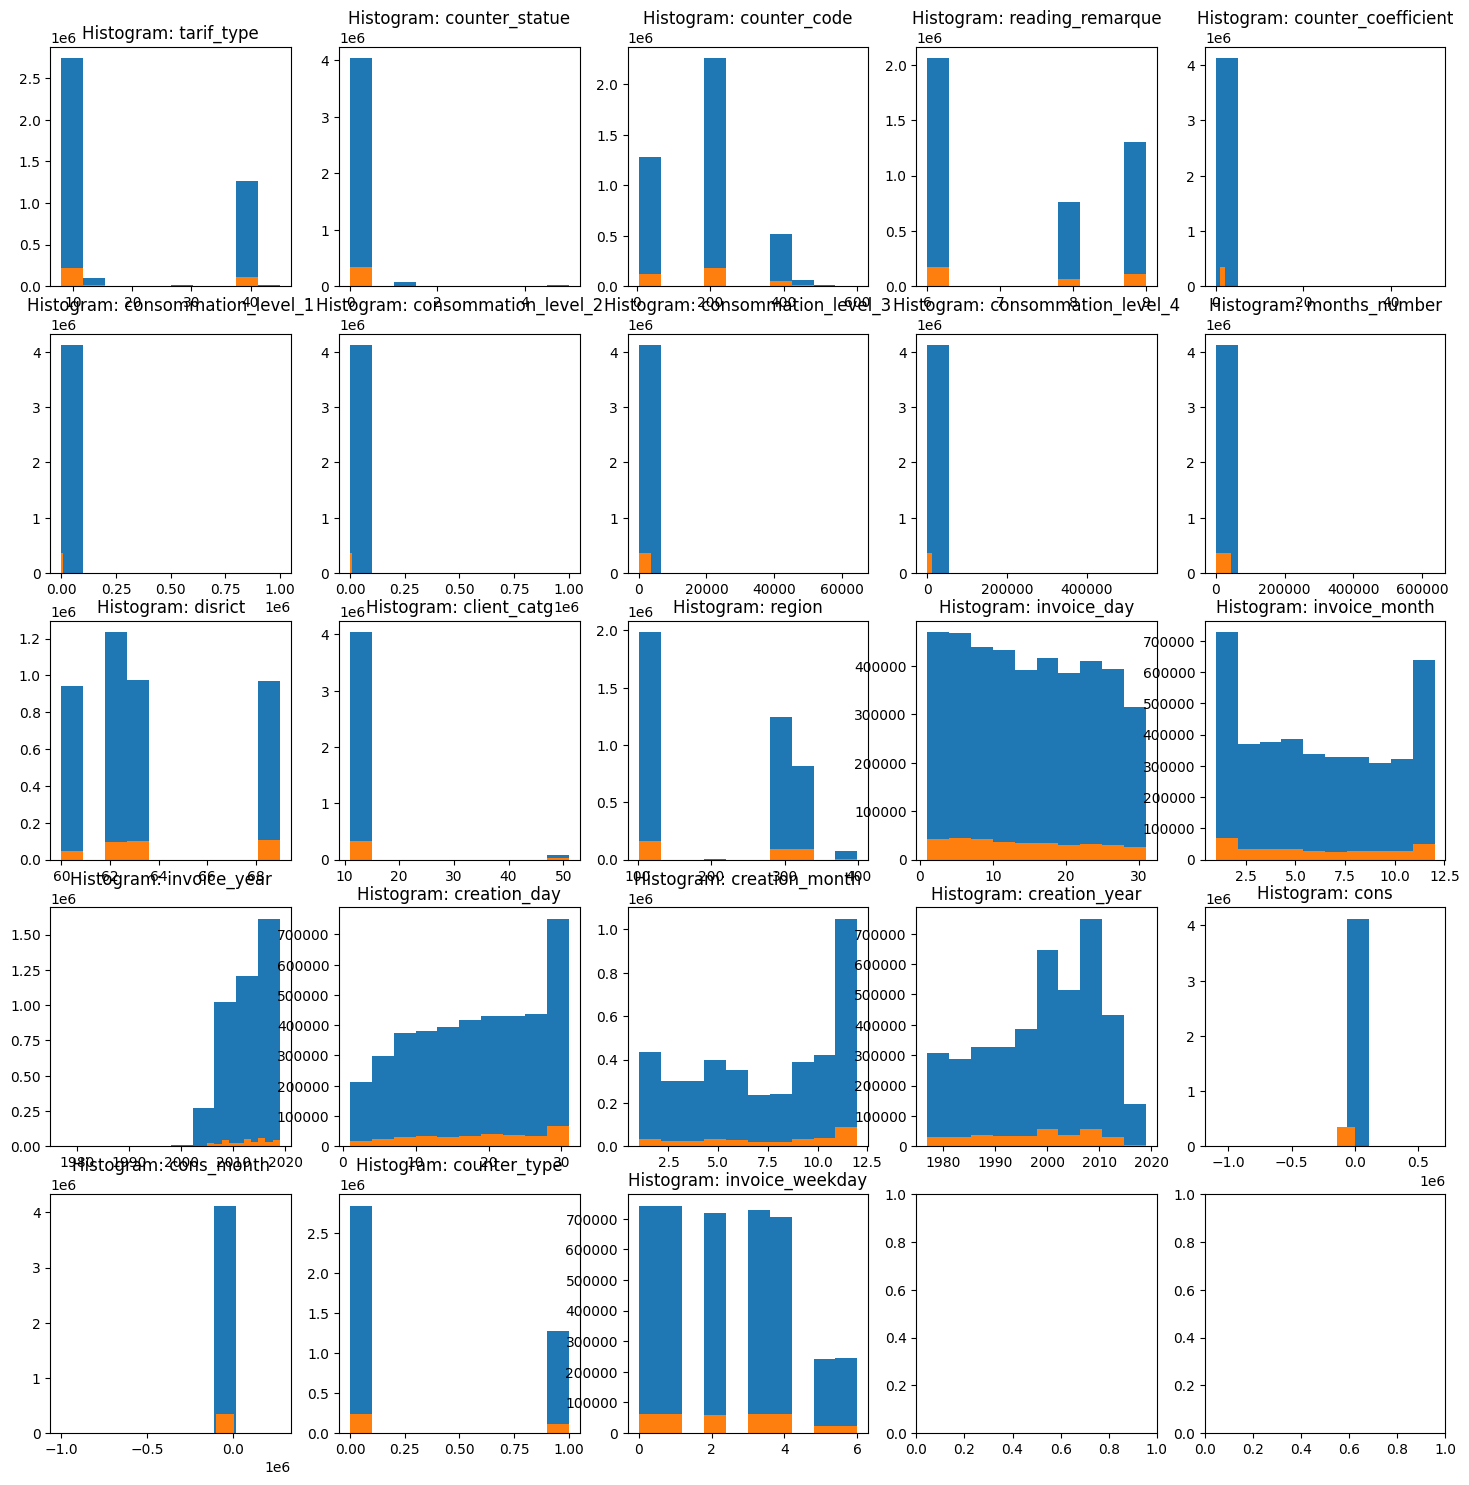

In [42]:
num_cols = ['tarif_type', 'counter_statue',
       'counter_code', 'reading_remarque', 'counter_coefficient',
       'consommation_level_1', 'consommation_level_2', 'consommation_level_3',
       'consommation_level_4', 'months_number',
       'disrict', 'client_catg', 'region', 'invoice_day',
       'invoice_month', 'invoice_year', 'creation_day', 'creation_month',
       'creation_year', 'cons', 'cons_month', 'counter_type','invoice_weekday']

fig, ax = plt.subplots(5, 5,figsize=(18,18))
ax = ax.ravel()

for i in range(len(num_cols)):
    print(num_cols[i])
    ax[i].set_title('Histogram: ' + num_cols[i])
    ax[i].hist(df.loc[df.target == 0, num_cols[i]])
    ax[i].hist(df.loc[df.target == 1, num_cols[i]])
  
plt.show()

(array([805542., 805246.,      0., 778607.,      0., 789844., 766814.,
             0., 263452., 267197.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

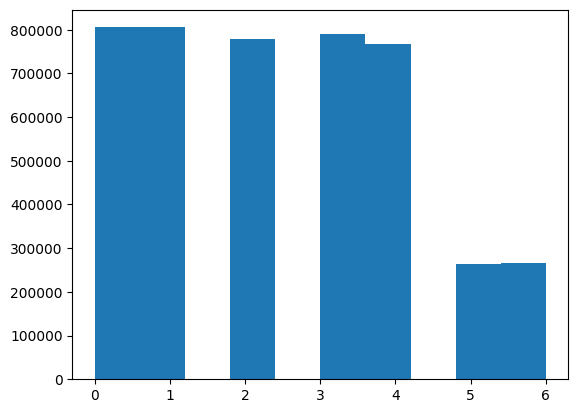

In [43]:
plt.hist(df['invoice_weekday'])

In [44]:
df.invoice_weekday.unique()

array([0, 4, 3, 1, 2, 6, 5], dtype=int32)

In [45]:
df.loc[(df.target==1)&(df.cons!=0),'cons'].shape[0]

1509

In [46]:
arr1 = np.where(df['cons']<=0,1,0)
arr1

array([1, 1, 1, ..., 1, 1, 1])

In [47]:
df[(df['cons']==0)&(df['target']==1)]

,client_id,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,...,target,invoice_day,invoice_month,invoice_year,creation_day,creation_month,creation_year,invoice_weekday,cons,cons_month
1384,train_Client_100032,11,393848,0,203,9,1,781,0,0,...,1.0,24,2,2017,7,11,2012,4,0,97.625
1385,train_Client_100032,11,393848,0,203,9,1,382,0,0,...,1.0,21,6,2016,7,11,2012,1,0,95.500
1386,train_Client_100032,11,393848,0,203,9,1,373,0,0,...,1.0,26,10,2018,7,11,2012,4,0,93.250
1387,train_Client_100032,11,393848,0,203,9,1,328,0,0,...,1.0,21,6,2018,7,11,2012,3,0,82.000
1388,train_Client_100032,11,393848,0,203,9,1,703,0,0,...,1.0,23,2,2018,7,11,2012,4,0,175.750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476230,train_Client_99982,10,1379797,0,202,8,1,200,192,0,...,1.0,22,11,2010,21,11,1995,0,0,98.000
4476231,train_Client_99982,10,1379797,0,202,6,1,200,98,0,...,1.0,19,7,2011,21,11,1995,1,0,74.500
4476232,train_Client_99982,10,1379797,0,202,8,1,187,0,0,...,1.0,19,3,2012,21,11,1995,0,0,46.750
4476233,train_Client_99982,10,1379797,0,202,8,1,95,0,0,...,1.0,21,3,2013,21,11,1995,3,0,23.750


In [48]:
df.drop(['cons'],axis=1)

,client_id,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,...,region,target,invoice_day,invoice_month,invoice_year,creation_day,creation_month,creation_year,invoice_weekday,cons_month
0,train_Client_0,11,1335667,0,203,8,1,82,0,0,...,101,0.0,24,3,2014,31,12,1994,0,20.500000
1,train_Client_0,11,1335667,0,203,6,1,1200,184,0,...,101,0.0,29,3,2013,31,12,1994,4,346.000000
2,train_Client_0,11,1335667,0,203,8,1,123,0,0,...,101,0.0,23,3,2015,31,12,1994,0,30.750000
3,train_Client_0,11,1335667,0,207,8,1,102,0,0,...,101,0.0,13,7,2015,31,12,1994,0,25.500000
4,train_Client_0,11,1335667,0,207,9,1,572,0,0,...,101,0.0,17,11,2016,31,12,1994,3,47.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476744,train_Client_99998,10,1253571,0,202,9,1,400,135,0,...,101,0.0,19,8,2005,22,12,1993,4,66.875000
4476745,train_Client_99998,10,1253571,0,202,6,1,200,6,0,...,101,0.0,19,12,2005,22,12,1993,0,51.500000
4476746,train_Client_99999,11,560948,0,203,6,1,259,0,0,...,101,0.0,25,9,1996,18,2,1986,2,64.750000
4476747,train_Client_99999,11,560948,0,203,6,1,603,0,0,...,101,0.0,28,5,1996,18,2,1986,1,150.750000


In [49]:
df.loc[(df.target == 1)&(df.counter_coefficient == 1)&(df.counter_number == 0),'disrict'].unique()

array([63])

In [50]:
df.counter_coefficient.unique()

array([ 1,  3,  0, 10,  4, 33, 50, 20,  2, 40, 30,  5, 11])

In [51]:
df[df.target == 1].counter_coefficient.unique()

array([ 1, 10,  5,  0])

In [52]:
df.groupby('counter_coefficient').count()

,client_id,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,...,target,invoice_day,invoice_month,invoice_year,creation_day,creation_month,creation_year,invoice_weekday,cons,cons_month
counter_coefficient,,,,,,,,,,,,,,,,,,,,,
0,46,46,46,46,46,46,46,46,46,46,...,46,46,46,46,46,46,46,46,46,45
1,4475089,4475089,4475089,4475089,4475089,4475089,4475089,4475089,4475089,4475089,...,4475089,4475089,4475089,4475089,4475089,4475089,4475089,4475089,4475089,4475089
2,886,886,886,886,886,886,886,886,886,886,...,886,886,886,886,886,886,886,886,886,886
3,321,321,321,321,321,321,321,321,321,321,...,321,321,321,321,321,321,321,321,321,321
4,12,12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12
5,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
10,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
11,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
20,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3


In [53]:
df[df.target == 1].groupby('counter_coefficient').count()

,client_id,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,...,target,invoice_day,invoice_month,invoice_year,creation_day,creation_month,creation_year,invoice_weekday,cons,cons_month
counter_coefficient,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,353109,353109,353109,353109,353109,353109,353109,353109,353109,353109,...,353109,353109,353109,353109,353109,353109,353109,353109,353109,353109
5,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
10,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [54]:
df[df.target == 0].groupby('counter_coefficient').count()

,client_id,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,...,target,invoice_day,invoice_month,invoice_year,creation_day,creation_month,creation_year,invoice_weekday,cons,cons_month
counter_coefficient,,,,,,,,,,,,,,,,,,,,,
0,45,45,45,45,45,45,45,45,45,45,...,45,45,45,45,45,45,45,45,45,44
1,4121980,4121980,4121980,4121980,4121980,4121980,4121980,4121980,4121980,4121980,...,4121980,4121980,4121980,4121980,4121980,4121980,4121980,4121980,4121980,4121980
2,886,886,886,886,886,886,886,886,886,886,...,886,886,886,886,886,886,886,886,886,886
3,321,321,321,321,321,321,321,321,321,321,...,321,321,321,321,321,321,321,321,321,321
4,12,12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12
10,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
11,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
20,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
30,137,137,137,137,137,137,137,137,137,137,...,137,137,137,137,137,137,137,137,137,137


In [55]:
df[df.target == 1]

,client_id,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,...,target,invoice_day,invoice_month,invoice_year,creation_day,creation_month,creation_year,invoice_weekday,cons,cons_month
1384,train_Client_100032,11,393848,0,203,9,1,781,0,0,...,1.0,24,2,2017,7,11,2012,4,0,97.625
1385,train_Client_100032,11,393848,0,203,9,1,382,0,0,...,1.0,21,6,2016,7,11,2012,1,0,95.500
1386,train_Client_100032,11,393848,0,203,9,1,373,0,0,...,1.0,26,10,2018,7,11,2012,4,0,93.250
1387,train_Client_100032,11,393848,0,203,9,1,328,0,0,...,1.0,21,6,2018,7,11,2012,3,0,82.000
1388,train_Client_100032,11,393848,0,203,9,1,703,0,0,...,1.0,23,2,2018,7,11,2012,4,0,175.750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476230,train_Client_99982,10,1379797,0,202,8,1,200,192,0,...,1.0,22,11,2010,21,11,1995,0,0,98.000
4476231,train_Client_99982,10,1379797,0,202,6,1,200,98,0,...,1.0,19,7,2011,21,11,1995,1,0,74.500
4476232,train_Client_99982,10,1379797,0,202,8,1,187,0,0,...,1.0,19,3,2012,21,11,1995,0,0,46.750
4476233,train_Client_99982,10,1379797,0,202,8,1,95,0,0,...,1.0,21,3,2013,21,11,1995,3,0,23.750


In [56]:
df[df.target == 1].groupby('counter_number').count()

,client_id,tarif_type,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,...,target,invoice_day,invoice_month,invoice_year,creation_day,creation_month,creation_year,invoice_weekday,cons,cons_month
counter_number,,,,,,,,,,,,,,,,,,,,,
0,3542,3542,3542,3542,3542,3542,3542,3542,3542,3542,...,3542,3542,3542,3542,3542,3542,3542,3542,3542,3542
4,42,42,42,42,42,42,42,42,42,42,...,42,42,42,42,42,42,42,42,42,42
7,23,23,23,23,23,23,23,23,23,23,...,23,23,23,23,23,23,23,23,23,23
37,40,40,40,40,40,40,40,40,40,40,...,40,40,40,40,40,40,40,40,40,40
42,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27191152351700,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
27191153130100,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
27191153138000,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [57]:
df[(df.target == 1)&(df.counter_coefficient == 1)&(df.counter_number == 0)&(df.disrict == 63)&(df.reading_remarque == 6)&(df.counter_code == 5)]

,client_id,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,...,target,invoice_day,invoice_month,invoice_year,creation_day,creation_month,creation_year,invoice_weekday,cons,cons_month
6417,train_Client_100177,40,0,0,5,6,1,0,0,0,...,1.0,20,12,2010,22,12,1998,0,0,0.0
6418,train_Client_100177,40,0,0,5,6,1,0,0,0,...,1.0,18,4,2013,22,12,1998,3,0,0.0
6421,train_Client_100177,40,0,0,5,6,1,0,0,0,...,1.0,8,12,2010,22,12,1998,2,0,0.0
6424,train_Client_100177,40,0,0,5,6,1,0,0,0,...,1.0,15,8,2011,22,12,1998,0,0,0.0
6434,train_Client_100177,40,0,0,5,6,1,0,0,0,...,1.0,19,12,2012,22,12,1998,2,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4465370,train_Client_99698,40,0,0,5,6,1,0,0,0,...,1.0,11,7,2012,17,9,1999,2,0,0.0
4465371,train_Client_99698,40,0,0,5,6,1,0,0,0,...,1.0,3,7,2012,17,9,1999,1,0,0.0
4465372,train_Client_99698,40,0,0,5,6,1,0,0,0,...,1.0,7,7,2011,17,9,1999,3,0,0.0
4465375,train_Client_99698,40,0,0,5,6,1,0,0,0,...,1.0,11,12,2013,17,9,1999,2,0,0.0


In [58]:
df[(df.counter_coefficient == 1)&(df.counter_number == 0)&(df.disrict == 63)&(df.reading_remarque == 6)&(df.counter_code == 5)]

,client_id,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,...,target,invoice_day,invoice_month,invoice_year,creation_day,creation_month,creation_year,invoice_weekday,cons,cons_month
573,train_Client_100011,40,0,0,5,6,1,0,0,0,...,0.0,5,4,2016,10,2,2012,1,0,0.0
587,train_Client_100011,40,0,0,5,6,1,0,0,0,...,0.0,5,4,2017,10,2,2012,2,0,0.0
603,train_Client_100011,40,0,0,5,6,1,0,0,0,...,0.0,13,1,2015,10,2,2012,1,0,0.0
604,train_Client_100011,40,0,0,5,6,1,0,0,0,...,0.0,9,5,2016,10,2,2012,0,0,0.0
605,train_Client_100011,40,0,0,5,6,1,0,0,0,...,0.0,1,12,2016,10,2,2012,3,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476675,train_Client_99996,40,0,0,5,6,1,0,0,0,...,0.0,19,6,2014,25,10,2012,3,0,0.0
4476676,train_Client_99996,40,0,1,5,6,1,0,0,0,...,0.0,17,6,2013,25,10,2012,0,0,0.0
4476677,train_Client_99996,40,0,0,5,6,1,0,0,0,...,0.0,21,2,2014,25,10,2012,4,0,0.0
4476679,train_Client_99996,40,0,1,5,6,1,0,0,0,...,0.0,22,10,2013,25,10,2012,1,0,0.0


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4476702 entries, 0 to 4476748
Data columns (total 28 columns):
 #   Column                Dtype  
---  ------                -----  
 0   client_id             object 
 1   tarif_type            int64  
 2   counter_number        int64  
 3   counter_statue        int64  
 4   counter_code          int64  
 5   reading_remarque      int64  
 6   counter_coefficient   int64  
 7   consommation_level_1  int64  
 8   consommation_level_2  int64  
 9   consommation_level_3  int64  
 10  consommation_level_4  int64  
 11  old_index             int64  
 12  new_index             int64  
 13  months_number         int64  
 14  counter_type          int64  
 15  disrict               int64  
 16  client_catg           int64  
 17  region                int64  
 18  target                float64
 19  invoice_day           int32  
 20  invoice_month         int32  
 21  invoice_year          int32  
 22  creation_day          int32  
 23  creation_mon

In [60]:
y = np.array(df.pop('target'))

In [61]:

X = df.drop(['client_id'], axis=1)

X

,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,...,region,invoice_day,invoice_month,invoice_year,creation_day,creation_month,creation_year,invoice_weekday,cons,cons_month
0,11,1335667,0,203,8,1,82,0,0,0,...,101,24,3,2014,31,12,1994,0,0,20.500000
1,11,1335667,0,203,6,1,1200,184,0,0,...,101,29,3,2013,31,12,1994,4,0,346.000000
2,11,1335667,0,203,8,1,123,0,0,0,...,101,23,3,2015,31,12,1994,0,0,30.750000
3,11,1335667,0,207,8,1,102,0,0,0,...,101,13,7,2015,31,12,1994,0,0,25.500000
4,11,1335667,0,207,9,1,572,0,0,0,...,101,17,11,2016,31,12,1994,3,0,47.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476744,10,1253571,0,202,9,1,400,135,0,0,...,101,19,8,2005,22,12,1993,4,0,66.875000
4476745,10,1253571,0,202,6,1,200,6,0,0,...,101,19,12,2005,22,12,1993,0,0,51.500000
4476746,11,560948,0,203,6,1,259,0,0,0,...,101,25,9,1996,18,2,1986,2,0,64.750000
4476747,11,560948,0,203,6,1,603,0,0,0,...,101,28,5,1996,18,2,1986,1,0,150.750000


In [62]:
X.isnull().sum()

tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
disrict                 0
client_catg             0
region                  0
invoice_day             0
invoice_month           0
invoice_year            0
creation_day            0
creation_month          0
creation_year           0
invoice_weekday         0
cons                    0
cons_month              1
dtype: int64

In [63]:
X = X.fillna(0)

In [64]:
y.shape

(4476702,)

In [65]:
# Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=RSEED)

In [66]:
# Creating column with coin flip results
number_rows = df.shape[0]
coinflip = np.random.randint(2, size=number_rows)
# Evaluating
cm = confusion_matrix(y,coinflip)
cm

array([[2063809, 2059781],
       [ 176880,  176232]])

In [67]:
print(classification_report(y,coinflip))

              precision    recall  f1-score   support

         0.0       0.92      0.50      0.65   4123590
         1.0       0.08      0.50      0.14    353112

    accuracy                           0.50   4476702
   macro avg       0.50      0.50      0.39   4476702
weighted avg       0.85      0.50      0.61   4476702



In [68]:

# for i in range(number_rows):
#     cons_pred = 1 if df.loc[i,'cons']<0 else 0
# cons_pred


In [69]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_test_pred_logreg = logreg.predict(X_test)
y_train_pred_logreg = logreg.predict(X_train)

In [70]:
cm = confusion_matrix(y_test, y_test_pred_logreg)
cm

array([[1237077,       0],
       [ 105934,       0]])

In [71]:
cm = confusion_matrix(y_train, y_train_pred_logreg)
cm

array([[2886513,       0],
       [ 247178,       0]])

In [72]:

# Initializing
forest = RandomForestClassifier(n_estimators=10, n_jobs=-1)
# Fitting and predicting
forest.fit(X_train,y_train)
y_test_pred_forest = forest.predict(X_test)

In [73]:
cm = confusion_matrix(y_test, y_test_pred_forest)
cm

array([[1235017,    2060],
       [  66176,   39758]])

In [74]:
# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, 
                                     [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, 
                                      [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    # plt.show();
    plt.savefig('image/nb1_roc_auc_curve.png')

evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)





def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)
    
    plt.savefig('image/nb1_cm.png')

# Confusion matrix
cm = confusion_matrix(test_labels, rf_predictions)
plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
                      title = 'Health Confusion Matrix')



NameError: name 'rf_predictions' is not defined

In [ ]:
forest2 = LGBMClassifier(n_estimators=10, n_jobs=-1)
# Fitting and predicting
forest2.fit(X_train,y_train)
y_test_pred_forest2 = forest2.predict(X_test)

[LightGBM] [Info] Number of positive: 247178, number of negative: 2886513
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2622
[LightGBM] [Info] Number of data points in the train set: 3133691, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.078878 -> initscore=-2.457696
[LightGBM] [Info] Start training from score -2.457696


In [ ]:
cm = confusion_matrix(y_test, y_test_pred_forest2)
cm

array([[1237077,       0],
       [ 105934,       0]])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4476702 entries, 0 to 4476748
Data columns (total 26 columns):
 #   Column                Dtype  
---  ------                -----  
 0   client_id             object 
 1   tarif_type            int64  
 2   counter_number        int64  
 3   counter_statue        int64  
 4   counter_code          int64  
 5   reading_remarque      int64  
 6   counter_coefficient   int64  
 7   consommation_level_1  int64  
 8   consommation_level_2  int64  
 9   consommation_level_3  int64  
 10  consommation_level_4  int64  
 11  old_index             int64  
 12  new_index             int64  
 13  months_number         int64  
 14  counter_type          int64  
 15  disrict               int64  
 16  client_catg           int64  
 17  region                int64  
 18  invoice_day           int32  
 19  invoice_month         int32  
 20  invoice_year          int32  
 21  creation_day          int32  
 22  creation_month        int32  
 23  creation_yea

In [ ]:
df.describe()

,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,...,client_catg,region,invoice_day,invoice_month,invoice_year,creation_day,creation_month,creation_year,cons,cons_month
count,4.476702e+06,4.476702e+06,4.476702e+06,4.476702e+06,4.476702e+06,4.476702e+06,4.476702e+06,4.476702e+06,4.476702e+06,4.476702e+06,...,4.476702e+06,4.476702e+06,4.476702e+06,4.476702e+06,4.476702e+06,4.476702e+06,4.476702e+06,4.476702e+06,4.476702e+06,4.476701e+06
mean,2.012812e+01,1.230600e+11,4.221523e-02,1.724897e+02,7.319695e+00,1.003000e+00,4.109838e+02,1.093191e+02,2.030642e+01,5.292644e+01,...,1.194382e+01,2.103581e+02,1.466321e+01,6.273777e+00,2.012735e+03,1.788532e+01,7.361081e+00,1.999037e+03,-1.098153e+01,1.578447e+02
std,1.347260e+01,1.657276e+12,3.745860e-01,1.338869e+02,1.359127e+00,3.079895e-01,7.573108e+02,1.220128e+03,1.574248e+02,8.754771e+02,...,6.022483e+00,1.035829e+02,8.583397e+00,3.432979e+00,4.104386e+00,8.700992e+00,3.478806e+00,1.058996e+01,4.568810e+03,2.234461e+03
min,8.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.100000e+01,1.010000e+02,1.000000e+00,1.000000e+00,1.977000e+03,1.000000e+00,1.000000e+00,1.977000e+03,-1.097806e+06,-9.985390e+05
25%,1.100000e+01,1.211100e+05,0.000000e+00,5.000000e+00,6.000000e+00,1.000000e+00,7.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,1.100000e+01,1.030000e+02,7.000000e+00,3.000000e+00,2.010000e+03,1.100000e+01,4.000000e+00,1.991000e+03,0.000000e+00,1.975000e+01
50%,1.100000e+01,4.945610e+05,0.000000e+00,2.030000e+02,8.000000e+00,1.000000e+00,2.740000e+02,0.000000e+00,0.000000e+00,0.000000e+00,...,1.100000e+01,3.010000e+02,1.400000e+01,6.000000e+00,2.013000e+03,1.800000e+01,8.000000e+00,2.001000e+03,0.000000e+00,7.641667e+01
75%,4.000000e+01,1.115161e+06,0.000000e+00,2.070000e+02,9.000000e+00,1.000000e+00,6.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,...,1.100000e+01,3.090000e+02,2.200000e+01,9.000000e+00,2.016000e+03,2.600000e+01,1.100000e+01,2.008000e+03,0.000000e+00,1.575000e+02
max,4.500000e+01,2.798115e+13,5.000000e+00,6.000000e+02,9.000000e+00,5.000000e+01,9.999100e+05,9.990730e+05,6.449200e+04,5.479460e+05,...,5.100000e+01,3.990000e+02,3.100000e+01,1.200000e+01,2.019000e+03,3.100000e+01,1.200000e+01,2.019000e+03,6.288110e+05,2.744730e+05


In [ ]:
stand = StandardScaler()
X_train_transform = stand.fit_transform(X_train)
X_text_transform= stand.transform(X_test)


In [ ]:
forest3 = LGBMClassifier(n_estimators=10, n_jobs=-1)
# Fitting and predicting
forest3.fit(X_train_transform ,y_train)
y_test_pred_forest3 = forest3.predict(X_text_transform)

[LightGBM] [Info] Number of positive: 247178, number of negative: 2886513
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 3133691, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.078878 -> initscore=-2.457696
[LightGBM] [Info] Start training from score -2.457696


In [ ]:
cm = confusion_matrix(y_test, y_test_pred_forest3)
cm

array([[1237077,       0],
       [ 105934,       0]])